# <img src="logo.png" alt="drawing" width="65"/> Finding Anomalies in Curriculum Access
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;_Christopher Mayorga & Ray Zapata_<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;July 22, 2021<br><br>

---
<br>



## Report Summary

In preparation of the upcoming board meeting, this notebook was created to answer several key questions posed by management with regard to access of Codeup curricula for web development and data science programs.

### Goals

There are several questions asked of the Codeup analyst team to find anomalies in user access in specific avenues of exploration:

- [Which lesson appears to attract the most traffic consistently across cohorts (per program)?](#Highest-Trafficked-Lesson)
- [Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?](#Low-Activity-Students)
- [Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?](#Suspicious-Activity)
- [At some point in 2019, the ability for students and alumni to access both curricula should have been shut off. Do you see any evidence of that happening? Did it happen before?](#Bi-Curriculum-Access)
- [What topics are grads continuing to reference after graduation and into their jobs (for each program)?](#Post-Grad-Activity)

The team set out to answer these questions utilizing the access log file in conjunction with the cohorts table available on the Codeup SQL `curriculum_logs` database.

### Findings

Answers discovered in exploration of the questions above revealed several important takeaways worth discussing. In searching for the most commonly accessed lessons in the Codeup programs, lesson overview pages were found to have the highest traffic to them. For web development this was pages such as _Javascript I_ and _HTML-CSS_, while for data science, _Classification_ and _MySQL_ were highest trafficked. This was found to be consistent when looking only at student traffic post graduation from the respective cohorts.

Students who were found to be the least active, defined as less than $1\%$ of the highest traffic among students, was distributed largely in cohorts for web development. As this program has an older history and therefore more cohorts having complete, it was not a surprising revelation. There were two users who were found to be within to cohorts, including one of which was simultaneous for two different programs. These anomalies are likely the result of inaccurate placement for the user or, more likely, a student level test account for administrative trouble shooting.

With regard to traffic presenting as unauthorized or suspicious, there was no traffic found to belong to a user not affiliated with a defined `user_id`, though there was substantial traffic for users who did not belong to a cohort. There was not found to be any substance in the division of these two populations when compared against the other, but it was found that users `341`, `422`, `570`, and `804` had substantial single-day traffic that was higher than even other outlier single-day traffic, particularly user `570` who had three days of above $230$ page loads.

Lastly, analyzing the data through $2019$ to find changes to traffic as a result of ending inter-program curriculum access, it was found that there was insufficient data to provide a more definitive answer to the question. While there was a dip in traffic after a minor surge in early January, there was no corresponding data for the same time frame in $2018$ to compare for analysis. It is possible that this dip was the result of access permission changes, especially given that there were still cohorts in progress at that time.

### Recommendations

These findings can be further explored with the insights gained in this initial venture. Clarification with admin responsible for this data can further alleviate existing mystery surrounding the results. For brevity in answering the specific questions asked of the analysis team for this report, the findings within are found to be adequate in presenting as is, and should this data need to be revisited at a later time, this report may serve as a launchpad for further query. In the interest of protecting Codeup assets and curriculum integrity, it is a more immediate recommendation to identify the users found with exorbitant traffic volume to determine any potential compromise that may have occurred and consult with the legal department as appropriate.

**Initialize Notebook**

In [1]:
# import standard libraries
import numpy as np
import pandas as pd

# import vissualization
import matplotlib.pyplot as plt
import seaborn as sns

# import acquire function
from wrangle import wrangle_curriculum

# cosmetic settings
import warnings
warnings.filterwarnings("ignore")
from matplotlib.pyplot import style
style.use('ggplot')

## Data Context
---

This data is acquired from a combination of the most recent access log `.txt` file, supplemented with user cohort data from the `cohorts` table in the `curriculum_logs` SQL database. For access to this information, please reach out to Codeup curriculum development. It is prepared by converting all date variables to the appropriate datetime data type and dropping columns unnecessary to answer the questions asked. All observations contain requisite values, and null values present are pertinent to several questions, and will kept in place.

In [2]:
# obtain data from acquire function
df = wrangle_curriculum()

## Anomaly Exploration
---
### Highest Trafficked Lesson

**Important Note:**
According to Codeup's Curriculum Developer Zach Gulde, Program 4 was a test program which ran before Codeup staff began tracking curriculum access. Because of this, our analysis will only focus on programs 1, 2, and 3.

In [3]:
# omit home page access records
c_df = pd.DataFrame(df[df.endpoint != '/'])
# omit table of contents access records
c_df = pd.DataFrame(c_df[c_df.endpoint != 'toc'])
# omit index.html because it doesn't provide insight
c_df = pd.DataFrame(c_df[c_df.endpoint != 'index.html'])
# omit search_index.json because it doesn't provide insight
c_df = pd.DataFrame(c_df[c_df.endpoint != 'search/search_index.json'])

In [4]:
# creating a list that has each program_id
program_list = [1, 2, 3]

In [5]:
# answer the question with a for loop
for prog in program_list:
    # aggregate by program_id and only return pages accessed with counts
    program_df = pd.DataFrame(c_df).groupby('program_id')['endpoint'].value_counts()
    # isolate df according to program_id
    cep_df = program_df.loc[[prog]]
    # only return the largest 3
    cep_df = cep_df.nlargest(3)
    print(cep_df)
    print('\n')

program_id  endpoint                         
1.0         javascript-i                         1144
            html-css                              979
            javascript-i/javascript-with-html     832
Name: endpoint, dtype: int64


program_id  endpoint    
2.0         javascript-i    19280
            java-iii        14153
            html-css        13777
Name: endpoint, dtype: int64


program_id  endpoint                                
3.0         classification/overview                     2455
            classification/scale_features_or_not.svg    2302
            sql/mysql-overview                          1723
Name: endpoint, dtype: int64




#### Findings
- Program 1: PHP Full Stack Web Development
    - Javascript I, HTML-CSS, Javascript with HTML
- Program 2: Java Full Stack Web Development
    - Javascript I, Java III, HTML-CSS
- Program 3: Data Science
    - Classfication Overview, Classification-Scaling Features, MySQL Overview

### Low Activity Students

In [6]:
# remove staff from the dataframe
r_df = df[df.cohort_name != 'Staff']

In [7]:
# subset data for access between student active dates
active_dates_df = r_df[(r_df.index >= r_df.start_date) & (r_df.index <= r_df.end_date)]
# group user id to find total page loads
active_access_df = active_dates_df.groupby(['cohort_name', 'user_id']).count()
# sort values by endpoint counts and pull carried over data from index
active_access_df = active_access_df.sort_values('endpoint').reset_index()[['user_id', 'cohort_name', 'endpoint']]
# find users who were less than 1% of the max access
one_percent_access = active_access_df[active_access_df.endpoint < active_access_df.endpoint.max() * .01]

In [8]:
# create list of user_id with access less than 1%
one_percent_access = one_percent_access.user_id.to_list()
# filter DataFrame for only users in the less than 1% acccess list
one_percent_access_df = active_dates_df[active_dates_df.user_id.isin(one_percent_access) == True]
print(one_percent_access, '| User Count:', len(one_percent_access))

[879, 940, 619, 918, 832, 663, 278, 539, 956, 895, 812, 388, 679, 941, 572, 697, 889, 487, 340, 49, 64, 24, 772, 41, 529, 371] | User Count: 26


In [9]:
one_percent_access_df.groupby(['user_id', 'cohort_name']).count()

,,endpoint,cohort_id,source_ip,start_date,end_date,program_id
user_id,cohort_name,,,,,,
24,Sequoia,26,26,26,26,26,26
41,Sequoia,28,28,28,28,28,28
49,Sequoia,25,25,25,25,25,25
64,Europa,25,25,25,25,25,25
278,Voyageurs,4,4,4,4,4,4
340,Zion,18,18,18,18,18,18
371,Yosemite,42,42,42,42,42,42
388,Andromeda,8,8,8,8,8,8
487,Bayes,17,17,17,17,17,17


In [10]:
# remove anomalous users from list
one_percent_access.remove(663)
one_percent_access.remove(895)
# create new columns for boolean when user in low_access
r_df['low_active_access'] = np.where(r_df.user_id.isin(one_percent_access) == True, 1, 0)

#### Findings

There are $26$ explicitly non-staff users whose sum access of any curriculum pages was less than $1\%$ of the highest user access, which was approximately $48$ total page loads. Two of these users, `user_id` $663$ and $895$ have access histories as members of two cohorts, where one count of traffic more expected of an active student. Having been part of the Florence cohort, there are no _students_ in the cohort, to my knowledge, who participated in two programs simultaneously. These two are either the result of user group misplacement or belong to staff-use, student level users for troubleshooting student access problems.

For the remainder of the users in the list, a new column called `low_active_access` is appended to the DataFrame to grab details about their use and traffic for any further questions.

### Suspicious Activity

In [11]:
# verify if there is access from null users
r_df[r_df.user_id.isna() == True]

,endpoint,user_id,cohort_id,source_ip,cohort_name,start_date,end_date,program_id,low_active_access
date,,,,,,,,,


In [12]:
# verify if there is access from non-cohort users
r_df[r_df.cohort_id.isna() == True]

,endpoint,user_id,cohort_id,source_ip,cohort_name,start_date,end_date,program_id,low_active_access
date,,,,,,,,,
2018-01-26,/,48,NaN,97.105.19.61,NaN,NaT,NaT,NaN,0
2018-01-26,spring/extra-features/form-validation,48,NaN,97.105.19.61,NaN,NaT,NaT,NaN,0
2018-01-26,/,48,NaN,97.105.19.61,NaN,NaT,NaT,NaN,0
2018-01-26,/,48,NaN,97.105.19.61,NaN,NaT,NaT,NaN,0
2018-01-26,mysql/relationships/joins,48,NaN,97.105.19.61,NaN,NaT,NaT,NaN,0
...,...,...,...,...,...,...,...,...,...
2021-07-12,java-i/syntax-types-and-variables,810,NaN,162.92.128.83,NaN,NaT,NaT,NaN,0
2021-07-13,/,727,NaN,172.58.96.119,NaN,NaT,NaT,NaN,0
2021-07-13,/,728,NaN,70.130.121.144,NaN,NaT,NaT,NaN,0


In [13]:
# check if there is a difference in total traffic for users
# who have known cohorts and those who do not

# resample to daily traffic and store preserved ip and user in index
unknowns_df = r_df[r_df.cohort_id.isna() == True].groupby(['user_id', 'source_ip'])\
                                             .endpoint.count()
knowns_df = r_df[r_df.cohort_id.isna() == False].groupby(['user_id', 'source_ip'])\
                                             .endpoint.count()
# pull variables out from index
unknowns_df = unknowns_df.reset_index()
knowns_df = knowns_df.reset_index()

In [14]:
# get first and third quartile for endpoint counts per user
q1, q3 = r_df.groupby('user_id').endpoint.count().quantile([0.25, 0.75])
# do math to get IQR
iqr = q3 - q1
# establish upper bound for plotting and filtering
upper_bound = q3 + 1.5 * iqr

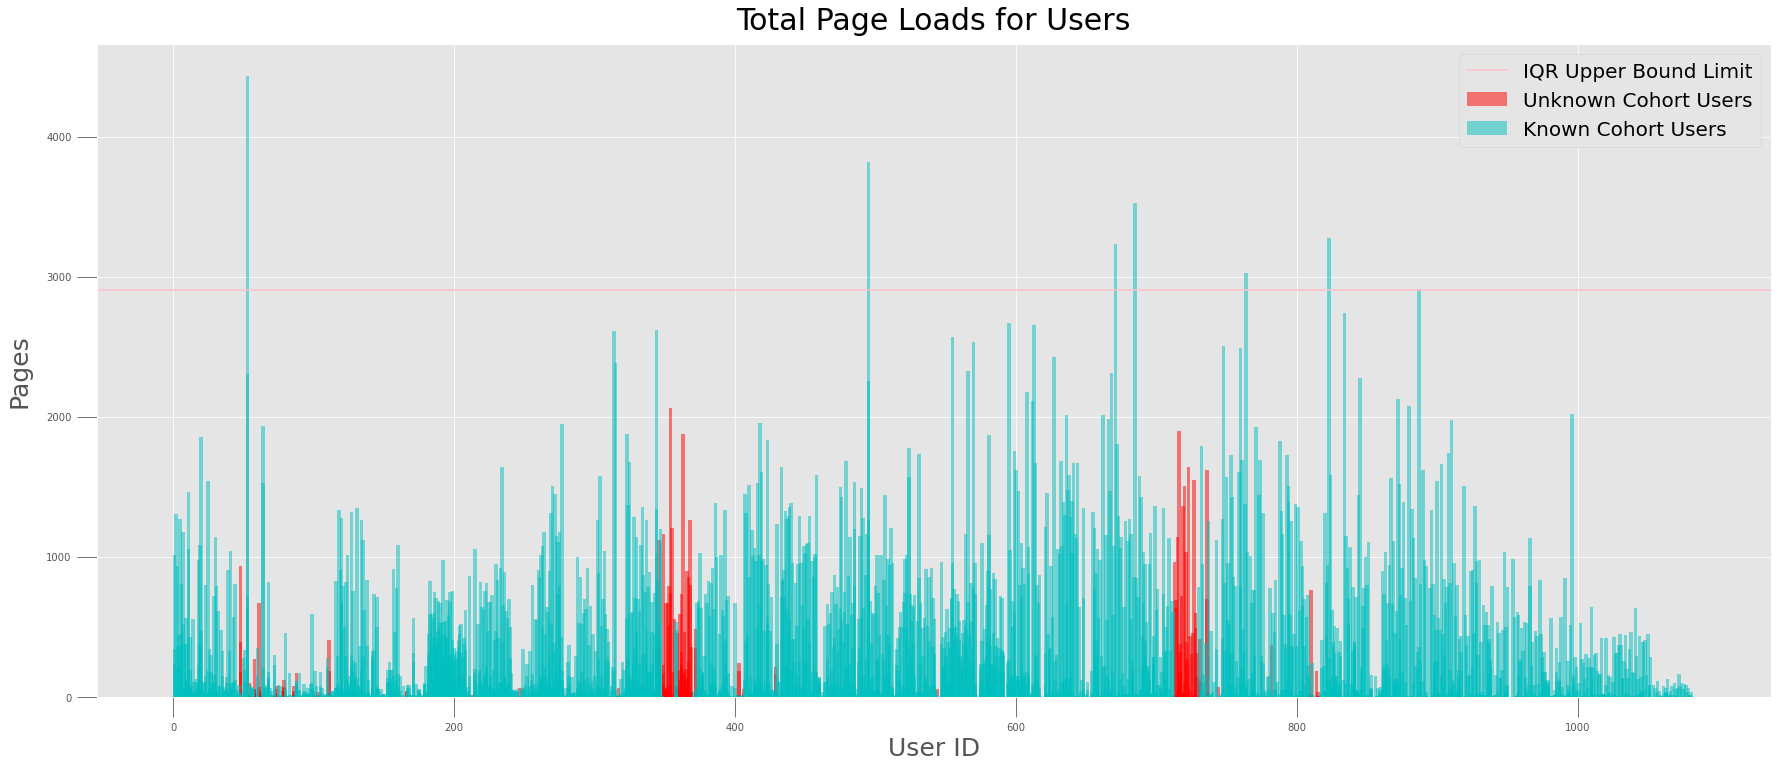

In [15]:
# create figure, axes
fig, ax = plt.subplots(figsize=(30,12))
# plot unknown users
ax.bar(unknowns_df.user_id,
       unknowns_df.endpoint,
       width=2.5,
       color='r', 
       alpha=0.5,
       label='Unknown Cohort Users')
# plot users with known cohort
ax.bar(knowns_df.user_id,
       knowns_df.endpoint,
       width=2.5,
       color='c',
       alpha=0.5,
       label='Known Cohort Users')
# plot ceiling for upper bound outliers
ax.axhline(y=upper_bound,
           label='IQR Upper Bound Limit',
           c='pink')
# set axis parameters
ax.tick_params(size=20, pad=5)
ax.set_xlabel('User ID', fontsize=25,)
ax.set_ylabel('Pages', fontsize=25, labelpad=15)
# increase legend fontsize
ax.legend(fontsize=20)
# create title
plt.title('Total Page Loads for Users', fontsize=30, pad=15)
# bring the pain
plt.show()

In [16]:
# create list of outlier users as plotted above
outlier_users = knowns_df[knowns_df.endpoint >= upper_bound].user_id.to_list()
# print list and count of users
print(outlier_users, ' User Count:', len(outlier_users), '\n')
# apply list to filter data from DataFrame
outlier_users_df = r_df[r_df.user_id.isin(outlier_users) == True]
# ouput DataFrame preview
outlier_users_df

[53, 495, 671, 685, 764, 823, 887]  User Count: 7 



,endpoint,user_id,cohort_id,source_ip,cohort_name,start_date,end_date,program_id,low_active_access
date,,,,,,,,,
2018-01-28,index.html,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,1.0,0
2018-01-28,html-css,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,1.0,0
2018-01-28,javascript-i,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,1.0,0
2018-01-28,javascript-i/conditionals,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,1.0,0
2018-01-28,javascript-i/conditionals,53,14.0,67.10.161.55,Lassen,2016-07-18,2016-11-10,1.0,0
...,...,...,...,...,...,...,...,...,...
2021-07-15,/,823,134.0,66.196.21.182,Luna,2020-12-07,2021-06-08,2.0,0
2021-07-15,java-ii,823,134.0,66.196.21.182,Luna,2020-12-07,2021-06-08,2.0,0
2021-07-15,java-i,823,134.0,66.196.21.182,Luna,2020-12-07,2021-06-08,2.0,0


#### Findings

Attempting to see if there was a difference in traffic from users with and without known cohorts resulted in clearly seeing that the users without known cohorts were fewer than the sum of cohort users and had traffic not dissimilar from other users. Looking instead at all user traffic to find atypical traffic within short time frames might be more useful in answering the question.

In [17]:
# create DataFrame of daily traffic per user
daily_traffic = r_df.groupby('user_id').resample('D').endpoint.count()
# pull user_id out of index and reset as data
daily_traffic = daily_traffic.reset_index().set_index('date')

In [18]:
# get q1 and q3 for hourly traffic counts, excluding 0
q1, q3 = daily_traffic[daily_traffic.endpoint > 0]\
                       .endpoint.quantile([0.25, 0.75])
# do math to get IQR
iqr = q3 - q1
# establish upper bound
upper_bound = q3 + 5 * iqr

In [19]:
# assign outliers in daily traffic to DataFrame
daily_traffic_outliers = daily_traffic[daily_traffic.endpoint > upper_bound]

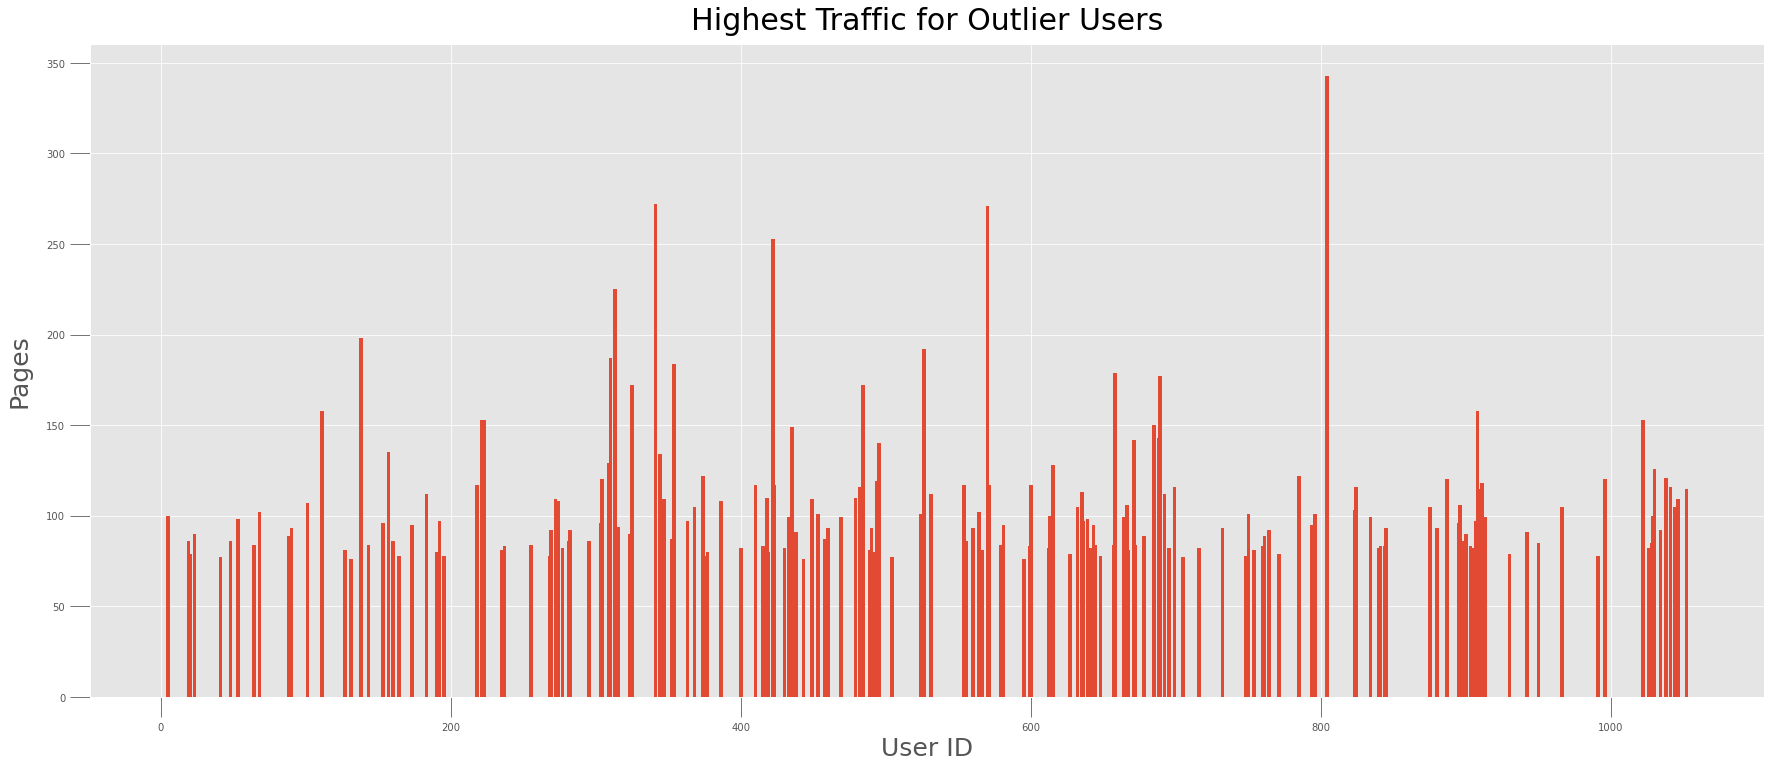

In [20]:
# create figure, axes
fig, ax = plt.subplots(figsize=(30,12))
# plot outliers to visualize disparity
ax.bar(daily_traffic_outliers.user_id,
       daily_traffic_outliers.endpoint,
       width=2.5)
# set axis parameters
ax.tick_params(size=20, pad=5)
ax.set_xlabel('User ID', fontsize=25,)
ax.set_ylabel('Pages', fontsize=25, labelpad=15)
# create title
plt.title('Highest Traffic for Outlier Users', fontsize=30, pad=15)
# plot that plot
plt.show()

In [21]:
# find outliers of the outliers
daily_traffic_outliers[daily_traffic_outliers.endpoint > 200]

,user_id,endpoint
date,,
2018-12-19,313,225
2019-03-03,341,272
2019-07-25,422,253
2020-04-05,570,232
2020-04-16,570,271
2020-04-26,570,234
2021-06-21,804,343


#### Additional Findings

Even among the outliers for daily traffic per user, there are further extreme outliers. Specifically, `user_id` $570$ has surpassed the extreme of $230$ pages in a single day three times in the same month. Even if there is a lesson that requires web scraping practices, this user has significantly surpassed any other student's access frequency. There is unlikely a legitimate reason for a student to be doing this as frequently and to the degree that is done.

In [22]:
# create DataFrame with unique IPs per user
unique_ips = pd.DataFrame(r_df.groupby('user_id').source_ip.unique())
# Add column for count of unique IPs per user
unique_ips['ip_count'] = unique_ips.source_ip.str.len()
# get first and third quartile for endpoint counts per user
q1, q3 = unique_ips.ip_count.quantile([0.25, 0.75])
# do math to get IQR
iqr = q3 - q1
# establish upper bound for plotting and filtering
upper_bound = q3 + 1.5 * iqr

In [23]:
# create DataFrame of users with IP count above upper bound
excessive_ips = unique_ips[unique_ips.ip_count > upper_bound]

In [24]:
excessive_ips

,source_ip,ip_count
user_id,,
3,"[97.105.19.61, 72.191.29.130, 72.181.117.226, ...",25
10,"[97.105.19.61, 12.247.3.42, 107.77.100.125, 16...",33
12,"[97.105.19.61, 76.185.247.126, 192.171.117.210...",22
15,"[97.105.19.61, 174.207.5.52, 174.207.1.185, 96...",20
52,"[99.203.26.41, 97.105.19.61, 99.203.26.214, 99...",23
...,...,...
979,"[107.77.217.122, 107.77.220.107, 107.77.222.49...",47
984,"[107.77.189.56, 107.77.189.18, 107.77.189.55, ...",52
985,"[73.85.64.161, 172.58.11.87, 172.58.11.244, 17...",90


**IP Access Findings**

There are $81$ users with counts of IP addresses above the outlier upper bounds. There are several same IPs across multiple users, which could indicate account sharing. There are also similar IP schemes among different users. This could be the result of local access while connected to the same Codeup network as the curriculum server. The users within the list warrant inspection to verify which IP addresses belong to the Codeup network to remove that was an explanation of the varying IPs. It is also possible that users utilize private VPNs for personal security, which would result in additional unique IP addresses connecting with the curriculum.

### Bi-Curriculum Access

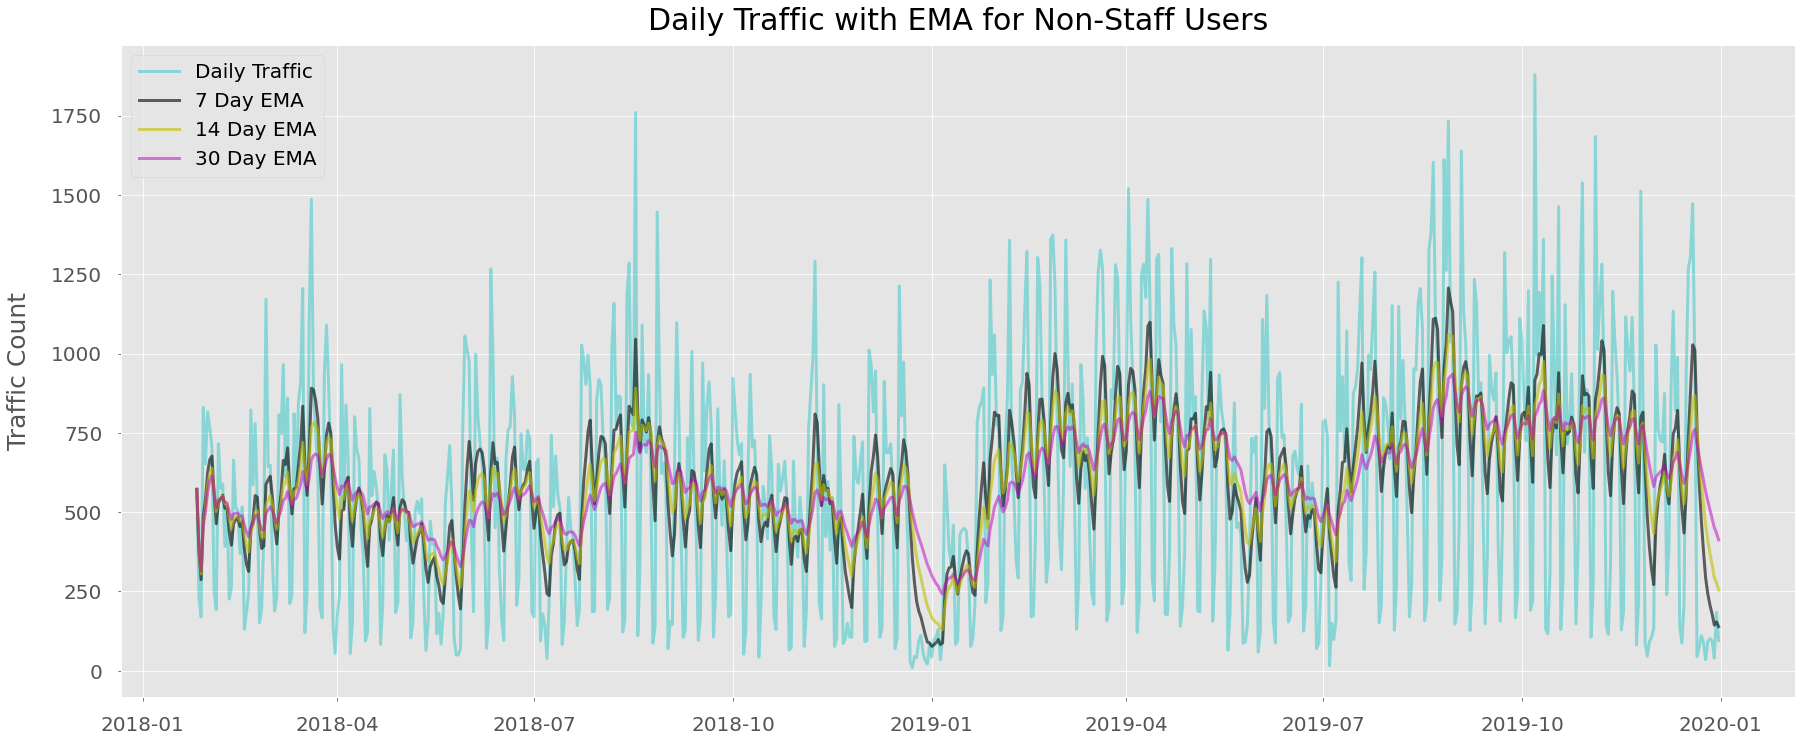

In [25]:
# resample data to daily endpoint counts
daily_df = df.resample('D').endpoint.count()[:'2019']
# create figure, axes
fig, ax = plt.subplots(figsize=(30,12))
# plot daily traffic
ax.plot(daily_df,
        c='c',
        alpha=0.4,
        linewidth=3,
        label='Daily Traffic')
# plot exp moving avg as 7 days for traffic
ax.plot(daily_df.ewm(span=7).mean(),
        color='k',
        alpha=0.6,
        linewidth=3,
        label='7 Day EMA')
# plot exp moving avg as 14 days for traffic
ax.plot(daily_df.ewm(span=14).mean(),
        color='y',
        alpha=0.6,
        linewidth=3,
        label='14 Day EMA')
# plot exp moving avg as 30 days for traffic
ax.plot(daily_df.ewm(span=30).mean(),
        color='m',
        alpha=0.5,
        linewidth=3,
        label='30 Day EMA')
# set axis parameters
plt.tick_params(labelsize=20, pad=15)
ax.set_xlabel('', labelpad=15)
ax.set_ylabel('Traffic Count', fontsize=25, labelpad=20)
# display legend and change fontsize
ax.legend(fontsize=20)
# create plot title
plt.title('Daily Traffic with EMA for Non-Staff Users', fontsize=30, pad=15)
# make all the above effort worth it
plt.show()

In [26]:
# list of start, end date cols
date_cols = ['start_date', 'end_date']
# create variable to filter dataframe to cohort start dates in 2018, 2019
date_subset = (df.start_date > '2018') & (df.start_date < '2020')
# output DataFrame of matching start and ends dates
df[date_cols][date_subset].groupby(date_cols).sum()

,
start_date,end_date
2018-01-08,2018-05-17
2018-03-05,2018-07-19
2018-05-29,2018-10-11
2018-07-23,2018-11-29
2018-09-17,2019-02-08
2018-11-05,2019-04-03
2019-01-22,2019-06-04
2019-03-18,2019-07-30
2019-05-28,2019-10-08


#### Findings

There does not appear to be any significant difference in traffic patterns from $2019$ to the previous year; however, there is data missing from the first weeks of the year in Jan $2018$, so it is possible that the dip in that same time frame during $2019$ may be result of bi-curriculum access being terminated. There are two active cohorts during that period, with at least two weeks remaining, and a new one begins around the period when traffic begins to surge up in late Jan $2019$. With no other factors to explain the decrease, it warrants looking into for further information if so desired.

### Post Grad Activity

In [27]:
# Make new column to see if they accessed after graduation
c_df['post-grad-access'] = c_df.index > c_df.end_date

In [28]:
# Turn boolean value into an integer
c_df['post-grad-access'] = c_df['post-grad-access'].astype(int)

In [29]:
# Do a loc on the df to get those who have accessed after graduation
post_grad = c_df.loc[c_df['post-grad-access'] == 1]

In [30]:
post_grad.head()

,endpoint,user_id,cohort_id,source_ip,cohort_name,start_date,end_date,program_id,post-grad-access
date,,,,,,,,,
2018-01-26,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,1
2018-01-26,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,1
2018-01-26,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1.0,1
2018-01-26,javascript-i,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,1
2018-01-26,javascript-i/functions,11,1.0,97.105.19.61,Arches,2014-02-04,2014-04-22,1.0,1


In [31]:
# answer the question with a for loop
for prog in program_list:
    # aggregate by program_id and only return pages accessed with counts
    program_df = pd.DataFrame(post_grad).groupby('program_id')['endpoint'].value_counts()
    # isolate df according to program_id
    cep_df = program_df.loc[[prog]]
    # only return the largest 3
    cep_df = cep_df.nlargest(3)
    print(cep_df)
    print('\n')

program_id  endpoint                         
1.0         javascript-i                         1144
            html-css                              979
            javascript-i/javascript-with-html     832
Name: endpoint, dtype: int64


program_id  endpoint    
2.0         javascript-i    4870
            spring          4342
            html-css        3532
Name: endpoint, dtype: int64


program_id  endpoint                                
3.0         classification/overview                     368
            sql/mysql-overview                          343
            classification/scale_features_or_not.svg    325
Name: endpoint, dtype: int64




#### Findings

- Program 1: PHP Full Stack Web Development
    - Javascript I, HTML-CSS, Javascript with HTML
- Program 2: Java Full Stack Web Development
    - Javascript I, Spring, HTML-CSS
- Program 3: Data Science
    - Classfication Overview, MySQL Overview, Classification-Scaling Features

### Least Accessed Lessons

In [32]:
# Get value counts for each page and store it into a variable
values = c_df.endpoint.value_counts()

In [33]:
# Turn it into a dataframe
values = pd.DataFrame(values)

In [34]:
# Take a look at the dataframe
values

,endpoint
javascript-i,21330
html-css,15334
java-iii,15245
java-ii,14593
spring,13886
...,...
',1
students/882/EDIT,1
stats/exam_scores.csv,1
itc-ml,1


As we can see from the following boxplot, value counts of endpoints (i.e. how many views a page has) have a huge spread. This is because there are a great deal of pages with very low views. For the purpose of this report, we believe it would be more useful to look at pages above a certain view count. To compute that number, we took the 3rd quartile (119.75) multiplied by 1.8, which resulted in 217. 

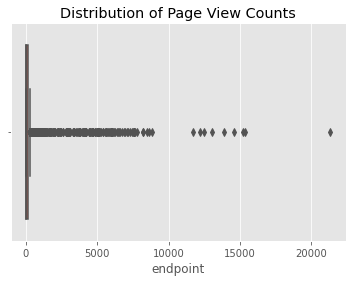

In [35]:
sns.boxplot(data=values, x='endpoint')
plt.title('Distribution of Page View Counts')
plt.show()

In [36]:
values.describe()

,endpoint
count,2402.000000
mean,382.405079
std,1400.917379
min,1.000000
25%,2.000000
50%,12.000000
75%,119.750000
max,21330.000000


In [37]:
119.75 * 1.82

217.94500000000002

In [38]:
# Take the value counts of endpoint column and apply a query to it so that we only see pages with a view count above 217
# Return the last 6 pages since these are the ones with the lowest views among that subset
c_df.endpoint.value_counts().reset_index(name='count').query('count > 217')['index'].tolist()[-6:]

['4-python/7.4.2-series',
 '10-anomaly-detection/3-discrete-probabilistic-methods',
 '9-timeseries/project',
 'individual-project/individual-project',
 '4-python/8.2-intro-to-matplotlib',
 '2-storytelling/2.2-create']

#### Findings
Overall least accessed lessons are:
- Python Series
- Anomaly detection: discrete probabilistic methods
- Time series project
- Individual project
- Python Intro to Matplotlib
- Storytelling: Create